# Movie Recommendation - Mission 1

### Movielense Dataset EDA


EDA(Exploratory Data Analysis)는 데이터셋을 다양한 각도에서 관찰하고 인사이트를 얻을 수 있는 중요한 데이터 분석 과정입니다. 이를 잘 수행하여 데이터의 특징과 분포에 대해 깊은 이해도를 가진다면, 모델의 성능에도 큰 영향을 끼칠 수 있습니다.

본 미션에서는 Movie Recommendation 대회를 위해 제공되는 [movielens](https://grouplens.org/datasets/movielens/) 를 재구성한 대회 데이터셋에 대한 EDA를 진행하고, 학습 데이터에 더불어 영화의 side-information 데이터에 대해 이해하는 시간을 가져보겠습니다!

## 대회 데이터셋 구성
먼저 데이터셋의 구성을 살펴봅니다.

### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

## train/test 데이터셋 알아보기

Pandas를 이용하여 train 데이터를 로드하고 데이터 구성을 알아봅니다. 이어지는 코드를 실행하면 데이터셋의 간략한 정보와 샘플을 확인할 수 있습니다.

train 데이터셋은 *user, item, time* 세개의 column으로 구성된 반면, test 데이터셋은 *user* column과 비어있는 *item* column으로 구성되어 있음을 참고해 주세요. 대회 진행시, 각각의 사용자에게 10개의 영화를 추천하게 됩니다.

각 column은 다음을 나타냅니다.
- *user*: 사용자 id.
- *item*: 영화 id.
- *time*: 사용자가 해당 영화와 interact한 시간. (UNIX시간의 초 단위)

영화 id는 *directors.tsv, genres.tsv, writers.tsv, years.tsv, titles.tsv*에서도 일관적으로 사용됩니다. 즉, 동일한 영화 id는 side information 데이터셋에서 동일한 영화를 나타냅니다.

이어지는 cell들을 실행해서 직접 관찰해보세요!

## 데이터 다운로드
이곳에 대회 사이트(AI Stages)에 있는 data의 URL을 입력해주세요. 
- 데이터 URL은 변경될 수 있습니다.
- 예) `!wget https://aistages-prod-server-public.s3.amazonaws.com/app/Competitions/000176/data/data.tar.gz`

In [1]:
direc_path = '/opt/ml/input/data'

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
data_path = os.path.join(direc_path,'train')
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [4]:
# train_df.info()

train_df.head(5)

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [5]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [6]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


데이터의 sparsity ratio는 약 97.6%로 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있습니다.

## 2 변수 상관관계 분석

### 유저, 장르

유저가 어떤 장르를 선호하는지 check

#### user별 genre 시청 횟수 dataframe

In [79]:
user_genre_df = pd.read_csv("./user_genre.csv")

user_genre_df.head()

,user,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,167,133,50,53,99,33,5,112,67,2,58,11,25,44,176,130,12,1
1,14,23,58,40,57,106,9,0,66,34,0,0,22,6,55,23,10,5,4
2,18,3,3,1,1,28,20,1,62,3,1,2,2,7,25,2,9,9,4
3,25,22,21,5,9,40,21,0,41,14,0,6,2,5,17,8,16,5,1
4,31,92,94,32,44,49,12,2,24,47,0,7,0,9,10,49,36,5,6


#### merge, get_dummies를 이용하여 user별 genre 시청 횟수 dataframe 간단하게 만들어보기

In [80]:
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')

In [81]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_df.head()

,user,item,time,genre
0,11,4643,1230782529,Action
1,11,4643,1230782529,Adventure
2,11,4643,1230782529,Drama
3,11,4643,1230782529,Sci-Fi
4,189,4643,1302945016,Action


In [33]:
genre_cat = genre_df['genre'].astype('category').values

genre_code = {g:i for i,g in enumerate(genre_cat.categories)}

genre_code

{'Action': 0,
 'Adventure': 1,
 'Animation': 2,
 'Children': 3,
 'Comedy': 4,
 'Crime': 5,
 'Documentary': 6,
 'Drama': 7,
 'Fantasy': 8,
 'Film-Noir': 9,
 'Horror': 10,
 'Musical': 11,
 'Mystery': 12,
 'Romance': 13,
 'Sci-Fi': 14,
 'Thriller': 15,
 'War': 16,
 'Western': 17}

In [34]:
genre_df['genre_code'] = genre_cat.codes

In [37]:
genre_one_hot = pd.get_dummies(genre_df['genre'])

In [38]:
genre_one_hot['user'] = genre_df['user']

In [42]:
for name, group in genre_one_hot.groupby('user'):
    print(name)
    print(group['Action'].sum()) # 이런 식으로 합치면 만들 수 있을 것 같다
    break

11
167


#### 만들어진 user_genre dataframe을 이용하여 user별 장르 선호도 뽑아내기

In [73]:
# 유저별 선호 장르 뽑아내기
# 1) use_mean == True: 평균 이상 시청한 장르 뽑아내기
# 2) use_mean == False: median 이상 시청한 장르 뽑아내기
def user_preference_genre(df,use_mean=True):
    users = np.unique(df['user'])
    genres = [c for c in df.columns if c != 'user']
    row = []
    for u in users:
        arr = df.loc[df['user'] == u, genres].to_numpy().squeeze()
        criteria = arr.mean() if use_mean else np.median(arr)
        r = [u] + list(np.where(arr >= criteria,1,0))
        row.append(r)
    user_pref_genre_df = pd.DataFrame(row, columns=df.columns)
    return user_pref_genre_df

In [74]:
user_pref_genre_mean = user_preference_genre(user_genre_df)

user_pref_genre_mean.head()

,user,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0
1,14,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0
2,18,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0
3,25,1,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0
4,31,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0


In [77]:
user_pref_genre_mean.head()

,user,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,1,1,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0
1,14,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0
2,18,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0
3,25,1,1,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0
4,31,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0


In [75]:
user_genre_df.head()

,user,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,167,133,50,53,99,33,5,112,67,2,58,11,25,44,176,130,12,1
1,14,23,58,40,57,106,9,0,66,34,0,0,22,6,55,23,10,5,4
2,18,3,3,1,1,28,20,1,62,3,1,2,2,7,25,2,9,9,4
3,25,22,21,5,9,40,21,0,41,14,0,6,2,5,17,8,16,5,1
4,31,92,94,32,44,49,12,2,24,47,0,7,0,9,10,49,36,5,6


In [78]:
print(len(user_pref_genre_mean))

31360


### timestamp(시청 시간), year(개봉 연도)

* 개봉연도는 1922-2014까지 다양하지만 시청연도는 2005-2015까지 비교적 현대이다
* 개봉연도에 맞게 시청을 했는지 살펴보려했지만 큰 의미가 없을 것 같다
* 유저가 몇년도에 개봉한 영화를 더 좋아하는지 살펴보는 것이 더 좋을 것같다.

In [84]:
import time

In [85]:
train_df.head()

,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [92]:
# year.tsv에 저장된 연도 구하기
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')

year = np.unique(year_data['year'])

year

array([1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014])

In [104]:
def time2year(t):
    return time.localtime(t).tm_year

In [107]:
# train_ratings.csv에 저장된 시간 현재 연도로 바꾸기
converted_year_df = train_df.copy()

converted_year_df['time'] = converted_year_df['time'].apply(time2year)

In [108]:
np.unique(converted_year_df['time'])

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

### user, director

* user가 어떤 감독의 영화를 선호는지 구하기

In [7]:
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

director_movie = np.unique(director_data['item'])
directors = np.unique(director_data['director'])

print(len(directors))
print(len(director_movie))

1340
5503


In [8]:
# train_rating.csv, directors.tsv 합치기

director_df = pd.merge(train_df, director_data, on=['item'])

director_df.head()

,user,item,time,director
0,11,4643,1230782529,nm0000318
1,189,4643,1302945016,nm0000318
2,294,4643,1288437662,nm0000318
3,383,4643,1261996844,nm0000318
4,421,4643,1190624541,nm0000318


In [9]:
director_df

,user,item,time,director
0,11,4643,1230782529,nm0000318
1,189,4643,1302945016,nm0000318
2,294,4643,1288437662,nm0000318
3,383,4643,1261996844,nm0000318
4,421,4643,1190624541,nm0000318
...,...,...,...,...
5407503,126426,102880,1386260290,nm0796117
5407504,127766,102880,1386261575,nm0796117
5407505,130972,102880,1391096866,nm0796117
5407506,131347,102880,1370143675,nm0796117


In [135]:
row = [ [u]+[0] * len(directors) for u in np.unique(train_df['user'])]

user_prefer_director_df = pd.DataFrame(row, columns=['user'] + list(directors))

In [136]:
user_prefer_director_df

,user,nm0000005,nm0000019,nm0000033,nm0000036,nm0000037,nm0000040,nm0000041,nm0000045,nm0000059,...,nm2284484,nm2304017,nm2320658,nm2480587,nm2482088,nm2588606,nm2648685,nm2676052,nm2879822,nm9054338
0,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31355,138473,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31356,138475,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31357,138486,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31358,138492,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 각 감독이 몇 편의 영화를 찍었는지 체크하기

In [38]:
movie_count_per_director = director_data['director'].value_counts()

movie_count_per_director

nm0000095    44
nm0000033    33
nm0000142    31
nm0000229    29
nm0000217    26
             ..
nm0404606     2
nm0405605     2
nm0410139     2
nm0410769     2
nm9054338     2
Name: director, Length: 1340, dtype: int64

In [53]:
max_count = max(movie_count_per_director)
min_count = min(movie_count_per_director)

x = np.arange(min_count,max_count+1,1)
y = []
for cnt in range(min_count,max_count+1):
    y.append((movie_count_per_director == cnt).sum())

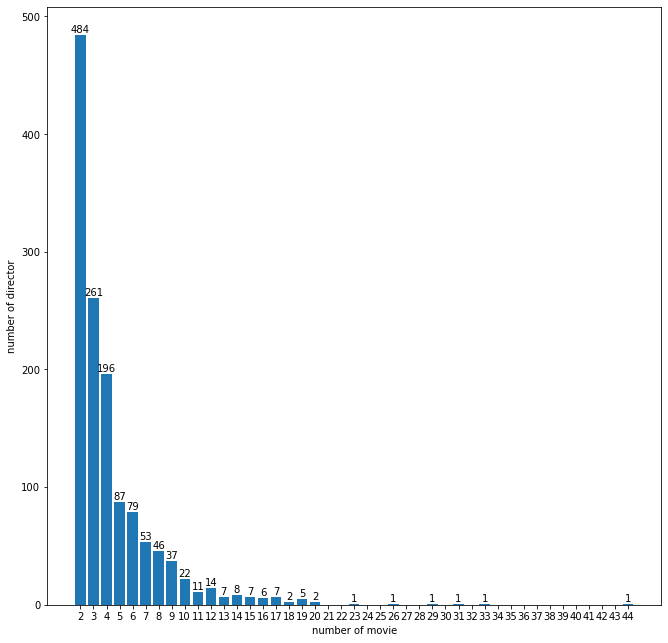

In [54]:
fig,ax = plt.subplots(figsize=(11,11))
ax.set_xticks(x)
ax.set_xlabel('number of movie')
ax.set_ylabel('number of director')
rects = ax.bar(x,y)

for rect in rects:
    x = rect.get_x()
    width = rect.get_width()
    height = int(rect.get_height())
    if height != 0:
        ax.text(x+width/2,height+2,str(height),ha='center')

In [68]:
def counting_director(movie_count_per_director,number_of_movie):
    return (movie_count_per_director >= number_of_movie).sum()

In [69]:
counting_director(movie_count_per_director,10)

97

보통 감독이 2편이상 찍었고 많게는 44편까지 찍은 감독도 존재한다.

* 총 감독 수: 1340명
* 총 20편 이상 찍은 감독: 8명 (약 0.5%)
* 총 15편 이상 찍은 감독: 35명 (약 2%)
* 총 10편 이상 찍은 감독: 97명 (약 7%)
* 총 5편 이상 찍은 감독: 399명 (약 29%)
* 총 3편 이상 찍은 감독: 856명 (약 63%)

#### 2편 이상 찍은 감독의 영화를 사람들이 얼마나 봤는지 체크하기

In [110]:
def director_make_k_movies(movie_count_per_director, k):
    return set([ i for i in movie_count_per_director.index if movie_count_per_director[i] >= k])

In [111]:
director_3 = director_make_k_movies(movie_count_per_director,3)
director_5 = director_make_k_movies(movie_count_per_director,5)
director_10 = director_make_k_movies(movie_count_per_director,10)
director_15 = director_make_k_movies(movie_count_per_director,15)
director_20 = director_make_k_movies(movie_count_per_director, 20)

In [113]:
def director_k_watched(director_df,director_k):
    return {director_id:director_df['director'].value_counts()[director_id] for director_id in director_df['director'].value_counts().index if director_id in director_k}

In [114]:
director_3_watched = director_k_watched(director_df, director_3)
director_5_watched = director_k_watched(director_df, director_5)
director_10_watched = director_k_watched(director_df, director_10)
director_15_watched = director_k_watched(director_df, director_15)
director_20_watched = director_k_watched(director_df, director_20)

In [120]:
def percentage_director_k_watched(director_df, k,director_watched):
    print(f"전체 시청 이력 수: {len(director_df)}")
    print(f"{k}편 이상 시청 이력 수: {sum(director_watched.values())}")
    print(f"{int(sum(director_watched.values())/len(director_df) * 100)}%")
    return int(sum(director_watched.values())/len(director_df) * 100)

In [121]:
director_3_p = percentage_director_k_watched(director_df,3,director_3_watched)
print("-----------------------------")
director_5_p = percentage_director_k_watched(director_df,5,director_5_watched)
print("-----------------------------")
director_10_p =percentage_director_k_watched(director_df,10,director_10_watched)
print("-----------------------------")
director_15_p = percentage_director_k_watched(director_df,15,director_15_watched)
print("-----------------------------")
director_20_p =percentage_director_k_watched(director_df,20,director_20_watched)
print("-----------------------------")

전체 시청 이력 수: 5407508
3편 이상 시청 이력 수: 4963672
91%
-----------------------------
전체 시청 이력 수: 5407508
5편 이상 시청 이력 수: 3933975
72%
-----------------------------
전체 시청 이력 수: 5407508
10편 이상 시청 이력 수: 1928963
35%
-----------------------------
전체 시청 이력 수: 5407508
15편 이상 시청 이력 수: 910779
16%
-----------------------------
전체 시청 이력 수: 5407508
20편 이상 시청 이력 수: 354766
6%
-----------------------------


* 총 감독 수: 1340명
    * 총 20편 이상 찍은 감독: 8명 (약 0.5%)
    * 총 15편 이상 찍은 감독: 35명 (약 2%)
    * 총 10편 이상 찍은 감독: 97명 (약 7%)
    * 총 5편 이상 찍은 감독: 399명 (약 29%)
    * 총 3편 이상 찍은 감독: 856명 (약 63%)

3편 이상 찍은 감독이 전체 시청 이력중 91% 정도 차지

나머지 39%의 감독(영화 갯수 2개)이 찍은 영화의 시청 이력은 9% 정도 차지

* 총 5407508 시청 이력 중
    * 20편 이상 찍은 감독의 영화를 본 이력이 354766 존재: 약 6%
    * 15편 이상 찍은 감독의 영화를 본 이력이 910779 존재: 약 16%
    * 10편 이상 찍은 감독의 영화를 본 이력이 1928963 존재: 약 35%
    * 5편 이상 찍은 감독의 영화를 본 이력이 3933975 존재: 약 72%
    * 3편 이상 찍은 감독의 영화를 본 이력이 4963672 존재: 약 91%

### user, writer

In [123]:
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
writer = np.unique(writer_data['writer'])
print(len(writer))

2989


In [124]:
writer_df = pd.merge(train_df, writer_data, on=['item'])

writer_df

,user,item,time,writer
0,11,4643,1230782529,nm0099541
1,11,4643,1230782529,nm0115310
2,11,4643,1230782529,nm0465199
3,11,4643,1230782529,nm0742797
4,189,4643,1302945016,nm0099541
...,...,...,...,...
11278910,130972,102880,1391096866,nm1729428
11278911,131347,102880,1370143675,nm0796117
11278912,131347,102880,1370143675,nm1729428
11278913,134144,102880,1371381972,nm0796117


train.csv와 writers.tsv 합치면 총 11278915 이력이 생성된다.

In [125]:
movie_count_per_writer = writer_data['writer'].value_counts()

movie_count_per_writer

nm0000095    47
nm0000636    35
nm0000175    32
nm0372942    30
nm0000108    29
             ..
nm0414893     2
nm0414448     2
nm0414117     2
nm0414047     2
nm5927608     2
Name: writer, Length: 2989, dtype: int64

In [126]:
writer_set = set(writer)
director_set = set(np.unique(director_data['director']))

print(len(writer_set))
print(len(director_set))

2989
1340


In [128]:
print(f"the number of writer and director: {len(writer_set & director_set)}")

the number of writer and director: 676


감독과 작가 수 비교
* 감독이면서 작가인 사람 총 676명
* 감독만: 664명
* 작가만: 2313명

In [130]:
max_count = max(movie_count_per_writer)
min_count = min(movie_count_per_writer)

x = np.arange(min_count,max_count+1,1)
y = []
for cnt in range(min_count,max_count+1):
    y.append((movie_count_per_writer == cnt).sum())

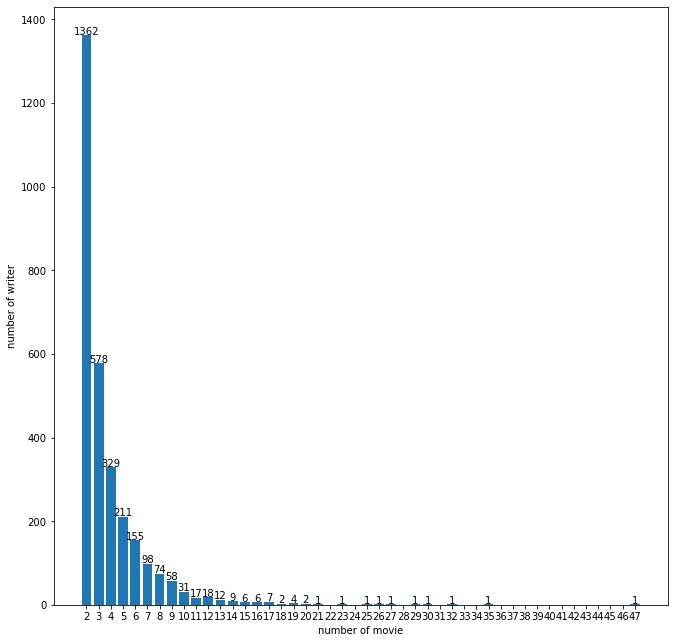

In [131]:
fig,ax = plt.subplots(figsize=(11,11))
ax.set_xticks(x)
ax.set_xlabel('number of movie')
ax.set_ylabel('number of writer')
rects = ax.bar(x,y)

for rect in rects:
    x = rect.get_x()
    width = rect.get_width()
    height = int(rect.get_height())
    if height != 0:
        ax.text(x+width/2,height+2,str(height),ha='center')

In [132]:
def counting_writer(movie_count_per_writer,number_of_movie):
    return (movie_count_per_writer >= number_of_movie).sum()

In [133]:
writer_20_count = counting_writer(movie_count_per_writer,20)
writer_15_count = counting_writer(movie_count_per_writer,15)
writer_10_count = counting_writer(movie_count_per_writer,10)
writer_5_count = counting_writer(movie_count_per_writer,5)
writer_3_count = counting_writer(movie_count_per_writer,3)

In [134]:
print(writer_20_count,writer_15_count,writer_10_count, writer_5_count, writer_3_count)

12 37 124 720 1627


전체 2989명의 작가중
* 20편 이상 쓴 작가: 12명 (0.4%)
* 15편 이상 쓴 작가: 37명 (1%)
* 10편 이상 쓴 작가: 124명 (4%)
* 5편 이상 쓴 작가: 720명 (24%)
* 3편 이상 쓴 작가: 1627명 (54%)

In [135]:
def writer_make_k_movies(movie_count_per_writer, k):
    return set([ i for i in movie_count_per_writer.index if movie_count_per_writer[i] >= k])

In [136]:
def writer_k_watched(writer_df,writer_k):
    return {writer_id:writer_df['writer'].value_counts()[writer_id] for writer_id in writer_df['writer'].value_counts().index if writer_id in writer_k}

In [138]:
writer_3 = writer_make_k_movies(movie_count_per_writer,3)
writer_5 = writer_make_k_movies(movie_count_per_writer,5)
writer_10 = writer_make_k_movies(movie_count_per_writer,10)
writer_15 = writer_make_k_movies(movie_count_per_writer,15)
writer_20 = writer_make_k_movies(movie_count_per_writer,20)

writer_3_watched = writer_k_watched(writer_df, writer_3)
writer_5_watched = writer_k_watched(writer_df, writer_5)
writer_10_watched = writer_k_watched(writer_df, writer_10)
writer_15_watched = writer_k_watched(writer_df, writer_15)
writer_20_watched = writer_k_watched(writer_df, writer_20)

In [139]:
def percentage_writer_k_watched(writer_df, k,writer_watched):
    print(f"전체 시청 이력 수: {len(writer_df)}")
    print(f"{k}편 이상 시청 이력 수: {sum(writer_watched.values())}")
    print(f"{int(sum(writer_watched.values())/len(writer_df) * 100)}%")
    return int(sum(writer_watched.values())/len(writer_df) * 100)

In [141]:
writer_3p = percentage_writer_k_watched(writer_df, 3,writer_3_watched)
print("-----------------------------")
writer_5p = percentage_writer_k_watched(writer_df, 5,writer_5_watched)
print("-----------------------------")
writer_10p = percentage_writer_k_watched(writer_df, 10,writer_10_watched)
print("-----------------------------")
writer_15p = percentage_writer_k_watched(writer_df, 15,writer_15_watched)
print("-----------------------------")
writer_20p = percentage_writer_k_watched(writer_df, 20,writer_20_watched)
print("-----------------------------")

전체 시청 이력 수: 11278915
3편 이상 시청 이력 수: 9472316
83%
-----------------------------
전체 시청 이력 수: 11278915
5편 이상 시청 이력 수: 6944398
61%
-----------------------------
전체 시청 이력 수: 11278915
10편 이상 시청 이력 수: 2442439
21%
-----------------------------
전체 시청 이력 수: 11278915
15편 이상 시청 이력 수: 1007528
8%
-----------------------------
전체 시청 이력 수: 11278915
20편 이상 시청 이력 수: 409338
3%
-----------------------------


### user, year

유저와 개봉 연도 사이의 관계, 유저가 몇년도에 출시한 영화를 즐겨보는지 확인

In [160]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')

year_data

,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
...,...,...
6802,7065,1915
6803,7243,1916
6804,8511,1917
6805,32898,1902


In [181]:
min_year = min(year_data['year'])
max_year = max(year_data['year'])

print(min_year, max_year)

1902 2015


#### year를 10년도로 끊어서 살펴보기

In [196]:
year_code = {i:t for i,t in enumerate(range(1900,2011,10))}

year_code

{0: 1900,
 1: 1910,
 2: 1920,
 3: 1930,
 4: 1940,
 5: 1950,
 6: 1960,
 7: 1970,
 8: 1980,
 9: 1990,
 10: 2000,
 11: 2010}

In [251]:
year_x = np.arange(1900,2011,10)
y = [0] * 12
for i in range(len(year_data)):
    y[(year_data['year'][i] - 1900) // 10] += 1

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

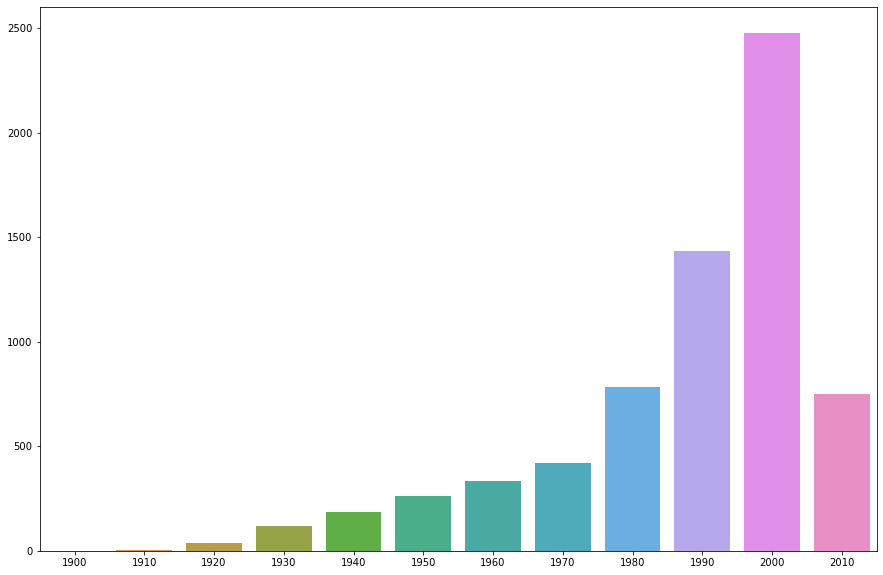

In [252]:
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(year_x,y,ax=ax)

# ax.set_xticks(x)

# for rect in rects:
#     x = rect.get_x()
#     width = rect.get_width()
#     rect.set_width(width * 5)
#     height = int(rect.get_height())
#     if height != 0:
#         ax.text(x+width/2,height+2,str(height),ha='center')

#### year를 5년씩 끊어서 살펴보기

In [243]:
year_x = np.arange(1900,2016,5)
y = [0] * len(year_x)
for i in range(len(year_data)):
    y[(year_data['year'][i] - 1900) // 5] += 1

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

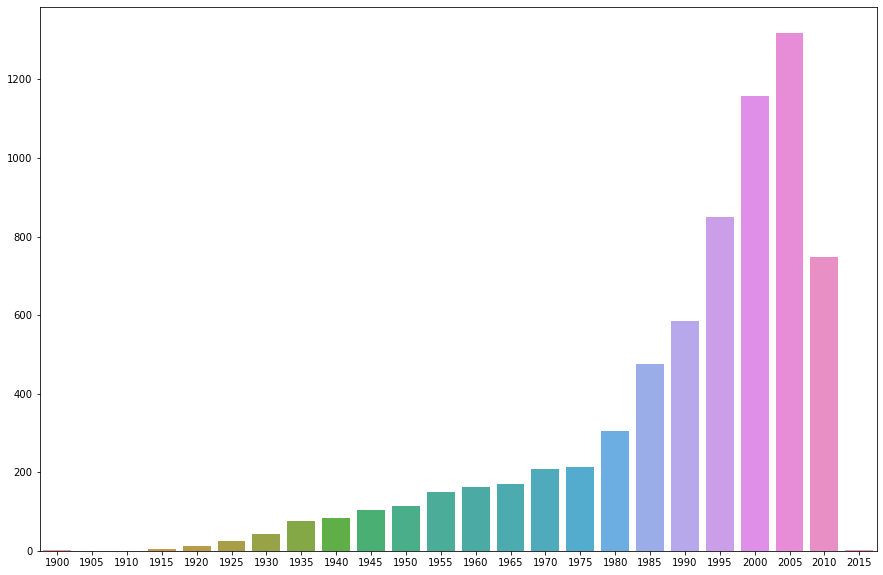

In [248]:
fig,ax = plt.subplots(figsize=(15,10))
sns.barplot(year_x,y,ax=ax)

# ax.set_xticks(year_x)
# ax.set_xlabel("year")
# ax.set_ylabel("the number of movies")

# for rect in rects:
#     x = rect.get_x()
#     width = rect.get_width()
#     height = int(rect.get_height())
#     if height != 0:
#         ax.text(x+width/2,height+2,str(height),ha='center')

5년씩 끊어서 갯수를 살펴봤기 때문에 x축에서 가리키는 2005가 2005년이 아니라 2005 ~ 2009년도 까지인 것에 주의!
2005 ~ 2009년도에 출시한 영화가 제일 많은 것 같다!

pie chart를 통해 비율을 살펴보자

In [218]:
ratio = np.array(y)
ratio = ratio / 6807
ratio = np.round(ratio * 100)

ratio

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,
        2.,  3.,  3.,  4.,  7.,  9., 12., 17., 19., 11.,  0.])

In [229]:
year_x

array([1900, 1905, 1910, 1915, 1920, 1925, 1930, 1935, 1940, 1945, 1950,
       1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005,
       2010, 2015])

([<matplotlib.patches.Wedge at 0x7f828cfd9dc0>,
 [Text(1.1, 0.0, '1900'),
  Text(1.1, 0.0, '1905'),
  Text(1.1, 0.0, '1910'),
  Text(1.1, 0.0, '1915'),
  Text(1.1, 0.0, '1920'),
  Text(1.1, 0.0, '1925'),
  Text(1.099434837843914, 0.0352567346066895, '1930'),
  Text(1.0949170244522488, 0.10562532634095854, '1935'),
  Text(1.085899962332452, 0.17555988097051112, '1940'),
  Text(1.0640243508090608, 0.2790200367094752, '1945'),
  Text(1.0196084363341997, 0.41279369733091653, '1950'),
  Text(0.958450580208442, 0.539789297131854, '1955'),
  Text(0.8815549926974782, 0.6579215719598722, '1960'),
  Text(0.7901842971706758, 0.7652507932076159, '1965'),
  Text(0.6579215977527268, 0.8815549734477706, '1970'),
  Text(0.4772721271135518, 0.9910657479100495, '1975'),
  Text(0.24477304438532255, 1.072420699512249, '1980'),
  Text(-0.14066486860268065, 1.0909690163982617, '1985'),
  Text(-0.6579215874355848, 0.8815549811476538, '1990'),
  Text(-1.0640243524417945, 0.2790200304831536, '1995'),
  Text(-0

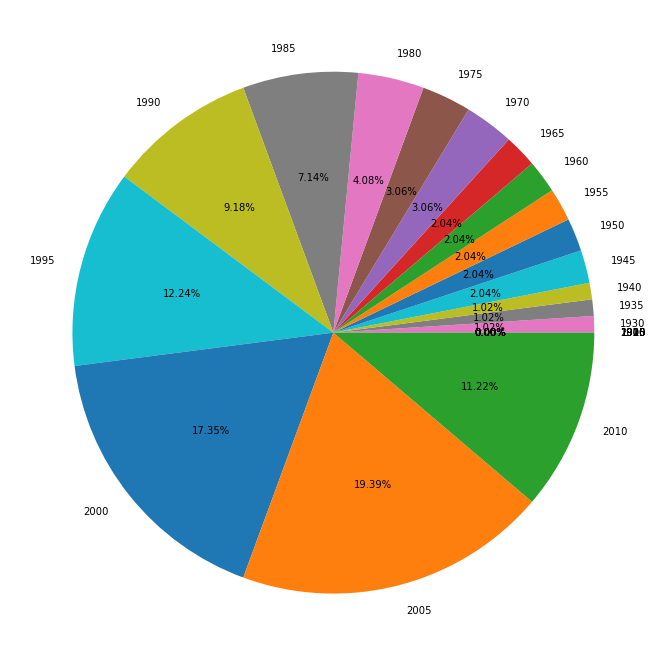

In [238]:
fig,ax = plt.subplots(figsize=(12,12))

plt.pie(ratio,labels = year_x,autopct='%.2f%%')

1995 ~ 2014까지의 영화가 60% 이상을 차지한다

유저가 시청한 영화를 5년씩 끊어서 살펴보자.

In [253]:
year_code = {i:y for i,y in enumerate(range(1900,2016,5))}

year_code

{0: 1900,
 1: 1905,
 2: 1910,
 3: 1915,
 4: 1920,
 5: 1925,
 6: 1930,
 7: 1935,
 8: 1940,
 9: 1945,
 10: 1950,
 11: 1955,
 12: 1960,
 13: 1965,
 14: 1970,
 15: 1975,
 16: 1980,
 17: 1985,
 18: 1990,
 19: 1995,
 20: 2000,
 21: 2005,
 22: 2010,
 23: 2015}

In [257]:
year_converted = train_df.copy()
year_converted['time'] = year_converted['time'].apply(time2year)

year_converted

,user,item,time
0,11,4643,2009
1,11,170,2009
2,11,531,2009
3,11,616,2009
4,11,2140,2009
...,...,...,...
5154466,138493,44022,2009
5154467,138493,4958,2009
5154468,138493,68319,2009
5154469,138493,40819,2009


In [258]:
def year_section(year):
    return (year - 1900 )// 5

In [260]:
year_converted['year_code'] = year_converted['time'].apply(year_section)

In [262]:
year_converted.head()

,user,item,time,year_code
0,11,4643,2009,21
1,11,170,2009,21
2,11,531,2009,21
3,11,616,2009,21
4,11,2140,2009,21


## Side Information 알아보기

다음은 side information 데이터를 알아봅니다. 일반적으로 추천시스템에서는 side information을 더욱 잘 활용할수록 더 좋은 추천 결과를 얻을 수 있게 됩니다.

주어진 year, writer, title, genre, director 데이터를 불러옵니다. 마찬가지로 각 데이터의 간략한 정보를 확인하고 샘플을 미리 저장해보겠습니다. 샘플된 데이터는 뒤에서도 계속 사용할 예정인 점을 참고해주세요! 그럼 다음 코드를 실행해보겠습니다.

In [7]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

그러면 먼저 *years.tsv* 데이터를 알아보겠습니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *year* : 해당 영화가 개봉한 연도.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

그리고 바로 이어지는 cell을 실행하여 추가적인 통계도 확인합니다. 데이터셋에 한 번 이상 출현하는 영화 작품은 총 6799편이며 평균 개봉 연도는 1992년인 등의 정보를 파악할 수 있습니다.

### year.tsv 결측치 확인
연도 정보가 모든 영화에 대해 존재하는 것이 아니다.

8개 정도 아이템에 대해 연도 정보가 존재하지 않는다.
* 연도 정보가 존재하지 않는 아이템: 3310, 6987, 6988, 7065, 7243, 8511, 32898, 119145


In [8]:
year_data.info()
year_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923


In [9]:
print ("Year data shape: ", year_data.shape)
print("Number of unique items in year_df: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())
print ("\nStatistics of year data: ")
year_data['year'].describe()

Year data shape:  (6799, 2)
Number of unique items in year_df:  6799
Number of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

In [10]:
year_item = np.unique(year_data['item'])
all_item = np.unique(train_df['item'])

print(f"number of unique movie item in years.tsv: {len(year_item)}")
print(f"number of unique movie item in train.csv: {len(all_item)}")

not_recorded_year = [item_id for item_id in all_item if item_id not in year_item]

print(not_recorded_year)

number of unique movie item in years.tsv: 6799
number of unique movie item in train.csv: 6807
[3310, 6987, 6988, 7065, 7243, 8511, 32898, 119145]


### writers.tsv 결측치 확인
작가 정보가 모든 영화마다 존재하는 것은 아니다

1159개 아이템에 대해 작가 정보가 존재하지 않는다.
* 연도 정보가 존재하지 않는 아이템: 3310, 6987, 6988, 7065, 7243, 8511, 32898, 119145


다음은 *writers.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *writer* : 영화의 각본가. (익명화)

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [11]:
writer_data.info()
writer_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
0,1237,nm0000005
1,5147,nm0000005


In [12]:
writer_item = np.unique(writer_data['item'])
writer = np.unique(writer_data['writer'])

print(f"number of unique item in writers.tsv: {len(writer_item)}")
print(f"number of unique writer in writers.tsv: {len(writer)}")

number of unique item in writers.tsv: 5648
number of unique writer in writers.tsv: 2989


In [13]:
print(f"number of missing item in writers.tsv: {len(all_item) - len(writer_item)}")
not_recorded_writer = [item_id for item_id in all_item if item_id not in writer_item]

# print(not_recorded_writer)

number of missing item in writers.tsv: 1159


다음은 *titles.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *titles* : 영화 제목.

다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

### titles.tsv에 대한 결측치 확인

모든 영화에 대해 이름이 존재한다.

In [14]:
title_item = np.unique(title_data['item'])
print(f"number of unique item in titles.tsv: {len(title_item)}")

number of unique item in titles.tsv: 6807


In [15]:
title_data.info()
title_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)


### genres.tsv 결측치 확인

모든 영화에 대해 장르가 존재한다.
* 장르 정보: 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'

다음은 *genres.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *genre* : 영화의 장르.

하나의 영화는 여러 개의 장르를 가질 수 있습니다.
다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [16]:
genre_data.info()
genre_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


In [17]:
genre_item = np.unique(genre_data['item'])
genre = np.unique(genre_data['genre'])
print(f"number of item in genres.tsv: {len(genre_item)}")
print(f"number of genres: {len(genre)}")

number of item in genres.tsv: 6807
number of genres: 18


In [18]:
genre

array(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

### directors.tsv 결측치 확인

* 1304개 정도의 영화에 대해 director 정보가 존재하지 않음

마지막으로 *directors.tsv* 데이터입니다. 
각 column은 다음과 같은 정보를 담고 있습니다:
- *item* : 영화 id.
- *director* : 영화 감독. (익명화)

하나의 영화는 여러 명의 감독을 가질 수 있습니다. 다음 코드를 실행하여 각 column의 data type과 같은 정보를 파악하고, 샘플 데이터를 출력해봅니다.

In [19]:
director_data.info()
director_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


In [20]:
director_item = np.unique(director_data['item'])
director = np.unique(director_data['director'])

print(f"number of item in directors.tsv: {len(director_item)}")
print(f"number of directors: {len(director)}")

number of item in directors.tsv: 5503
number of directors: 1340


In [21]:
print(f"number of missing item in directors.tsv: {len(all_item) - len(director_item)}")
not_recorded_director = [item_id for item_id in all_item if item_id not in director_item]
print(len(not_recorded_director))

number of missing item in directors.tsv: 1304
1304


## 데이터 결측치 종합
* years.tsv: 8개
* writers.tsv: 1159개
* directors.tsv: 1304개
* genres.tsv: 0개
* titles.tsv: 0개

## 데이터 시각화 해보기
앞에서 주어진 데이터셋을 먼저 간단히 살펴보았습니다. 이제부터는 다수의 파일을 merge하여 시각화하고, 데이터에 대해 좀 더 깊은 이해를 해보겠습니다.

먼저 효율적인 데이터 시각화를 위해, 데이터셋에서 빈도수가 높은 movie, user 데이터의 id를 미리 저장하겠습니다.
train 데이터에서 데이터의 출현 빈도 순으로 *active_user_ids*와 *popular_movie_ids*에 top 10을 각각 저장합니다.

대회 데이터셋에서 빈도수가 높을수록 유명한 영화를 나타내는 것은 아니지만, 편의상 *popular_movie_id* 변수명을 사용하는 점을 당부드립니다.

다음 코드를 실행해주세요.

In [26]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


*active_user_ids*와 *popular_movie_ids*에 각각 빈도가 높은 영화와 사용자 id들을 저장했습니다. 뒤에서도 계속 사용할 예정이니 참고해 주세요.

이제부터는 train 데이터와 side information 데이터를 merge하고, side information 별 user-item 빈도수가 높은 데이터 샘플을 미리 저장합니다. 위에서 저장한 active user id와 popular movie id와 다르게 여기서는 바로 Pandas Dataframe의 형태로 샘플을 저장합니다. 빈도가 가장 높은 10개 side information data가 해당하는 모든 user-item interaction를 저장할 것이므로, 각 side information 데이터 샘플의 크기는 상이합니다.

이어지는 코드 cell들을 실행해보고, 출력된 결과를 충분히 관찰해보시기 바랍니다.

In [27]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

side_df = []
for director in director_id:
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user  item        time   director
1565258  120515  4226  1134795734  nm0634240
2543730  128095    47  1171634815  nm0000399
3113745   99566  5010  1409361657  nm0000631
2945072   34656  1394  1181759139  nm0001054
1043862   33387  1198  1144625456  nm0000229

shape of the data:  (672019, 4)


In [28]:
np.unique(director_top['director'])

array(['nm0000116', 'nm0000217', 'nm0000229', 'nm0000233', 'nm0000399',
       'nm0000631', 'nm0000709', 'nm0001054', 'nm0001392', 'nm0634240'],
      dtype=object)

In [30]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
           user  item        time     writer
3677395  29811  7153  1237389452  nm0101991
2251428  39003  1210  1270502172  nm0000184
5064048  28571  1258  1423573311  nm0000175
1754231  64904  6377  1256535735  nm0004056
543666   36806   260  1293418057  nm0000184

shape of the data:  (651286, 4)


In [31]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]

side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6806

top 10 movie titles: 
 Index(['Matrix, The (1999)', 'Fight Club (1999)', 'Pulp Fiction (1994)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)',
       'Lord of the Rings: The Fellowship of the Ring, The (2001)',
       'Lord of the Rings: The Return of the King, The (2003)',
       'Lord of the Rings: The Two Towers, The (2002)',
       'Silence of the Lambs, The (1991)', 'American Beauty (1999)'],
      dtype='object', name='title')

sample of top 10 user-title data: 
           user  item        time  \
113112   50645  2858  1233080999   
847669  119047   296  1320685410   
882713  132674   593  1118900306   
584723    8007  4993  1139091455   
227995   38873  2571  1294983053   

                                                    title  
113112                             American Beauty (1999)  
847669                                Pulp Fiction (1994)  
882713                   Silence of the Lambs, The (1991)  
584723  

In [33]:
title_top.head(5)

,user,item,time,title
222427,11,2571,1230787515,"Matrix, The (1999)"
222428,25,2571,1277963409,"Matrix, The (1999)"
222429,31,2571,1424736532,"Matrix, The (1999)"
222430,35,2571,1164499279,"Matrix, The (1999)"
222431,43,2571,1239308964,"Matrix, The (1999)"


In [34]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 [1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935
 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014]

Number of all unique years:  93

top 10 years: 
 Int64Index([2004, 1999, 2001, 2002, 2006, 2003, 2000, 2005, 1995, 2007], dtype='int64', name='year')

sample of top 10 user-year data: 
            user   item        time  year
1158581   53017  41566  1228182966  2005
237915   108616   2571  1266701515  1999
2475163   11335   3148  1359510857  1999
1135438   19564   4896  1379862447  2001
3787722  122363   4641  1413950505  2001

shape of the data:  (2173226, 4)


여기까지 director, writer, title, year 데이터를 확인해 보았는데요. 이어서 genre 데이터도 관찰해보겠습니다. 데이터셋에서 genre의 수가 총 18개밖에 없으므로 빈도수가 높은 genre를 따로 저장할 필요 없이, train 데이터와의 merge를 바로 진행하겠습니다.

다음 코드를 실행하고 genre 데이터의 형태도 관찰해보세요.

In [39]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
             user  item        time      genre
9223811   112232  3034  1397181596  Animation
13273853     572  2841  1324352141   Thriller
1920736    52396  1073  1304518986    Fantasy
886861     44070  1690  1347380231     Horror
12456816   31233  7121  1256226033     Comedy

shape of the data:  (14126324, 4)


In [47]:
genre_top.loc[genre_top['item'] == 3034]

,user,item,time,genre
9218385,85,3034,1400427602,Adventure
9218386,85,3034,1400427602,Animation
9218387,85,3034,1400427602,Children
9218388,85,3034,1400427602,Comedy
9218389,85,3034,1400427602,Musical
...,...,...,...,...
9225045,138493,3034,1256750404,Adventure
9225046,138493,3034,1256750404,Animation
9225047,138493,3034,1256750404,Children
9225048,138493,3034,1256750404,Comedy


여기까지 오셨으면 side information 데이터의 형태를 충분히 파악하셨을 것으로 생각됩니다! 이제
matplotlib library를 사용하여 샘플한 데이터를 그래프로 시각화해봅니다. 

In [37]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

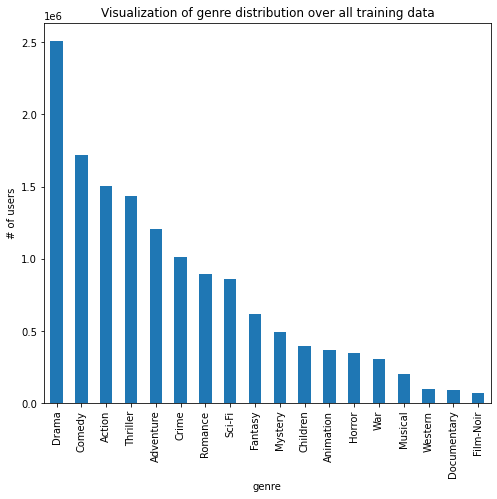

In [38]:
genre_top['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')
plt.show

데이터셋에서 가장 많이 출현하는 장르가 *Drama*, 가장 적게 출현하는 장르가 *Film-Noir*임을 확인할 수 있었습니다.

그러면 전체 training 데이터에서의 genre 분포 뿐만 아니라, genre 데이터 단독의 분포를 출력하면 어떤지 비교해 봅니다. 코드를 실행해주세요.

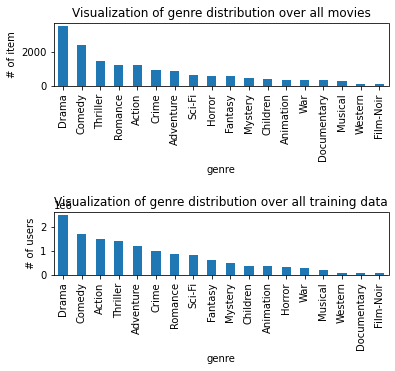

In [50]:
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of item')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

Text(0.5, 1.0, 'Visualization of genre distribution over all movies')

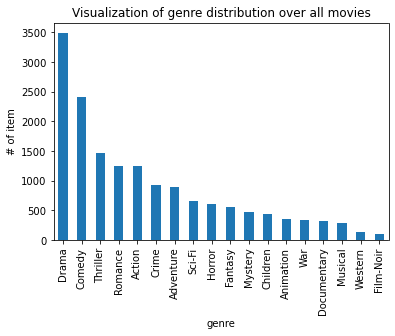

In [51]:
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of item')
plt.title('Visualization of genre distribution over all movies')

In [59]:
print(genre_top['genre'].value_counts())

Drama          2511407
Comedy         1719017
Action         1504902
Thriller       1435678
Adventure      1203283
Crime          1014480
Romance         893843
Sci-Fi          857851
Fantasy         617807
Mystery         493005
Children        397929
Animation       370761
Horror          343730
War             307170
Musical         199635
Western          95374
Documentary      90050
Film-Noir        70402
Name: genre, dtype: int64


Text(0.5, 1.0, 'Visualization of genre distribution over all training data')

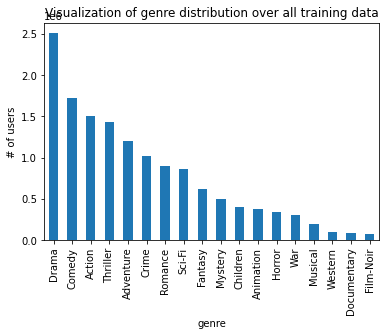

In [52]:
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

두 개의 그래프를 확인하면 거의 비슷해보이지만, 두 분포 사이에 작은 차이가 있음을 확인할 수 있습니다. 가령, *Romance* 장르의 영화가 전체 훈련 데이터에서는 7위를 차지하지만, 모든 6807개의 영화 중에서는 4위를 차지합니다. 이는 *Romance* 장르에 해당하는 영화의 갯수에 비해 실제 사용자들이 시청할 확률이 더 높았다는 것을 뜻합니다. -> 모든 영화들이 다 

다음은 사용자 한명이 시청한 영화 리스트를 확인하고, 해당 사용자가 가장 선호하는 장르를 순위별로 차트로 알아보겠습니다. 다음 코드에서는 데이터가 가장 많은 사용자의 id인 `active_user_ids[0]`를 사용하겠습니다.
그럼 코드를 실행해보세요!

<AxesSubplot:>

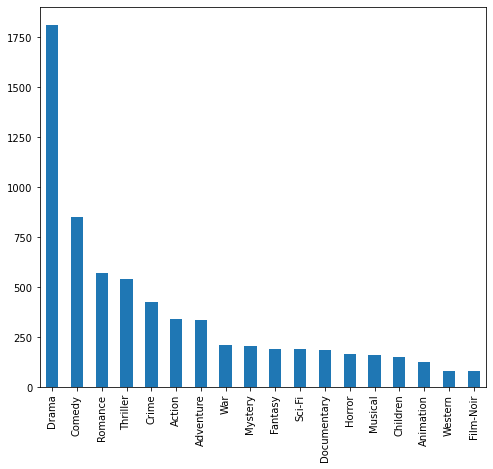

In [60]:
user_id = active_user_ids[0] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

`active_user_ids[0]`에 해당하는 사용자의 시청영화 장르 분포는 전체 데이터의 장르 분포와 크게 차이가 나지 않습니다. 그렇다면 `active_user_ids[1]`에 해당하는 사용자는 어떨까요? 다양한 사용자들의 장르 분포도 한번 비교해 보시기 바랍니다.


다음은 사용자가 주로 언제 영화를 시청했는지 알아보려고 합니다.
그 전에 먼저 간단히 알고 넘어가면 좋은 내용이 있는데요. train 데이터를 보시면 timestamp column은 유닉스 시간(Unix time)을 초 단위로 표시한 것입니다. 통계를 위해 이것을 우리가 알아볼 수 있는 단위로 변환하는 방법을 알아보겠습니다. 다음 코드를 실행해보세요.

In [61]:
import time
unix_time = 1230782529 # some random timestamp from dataset
converted_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(unix_time))

print ("initial unix-based timestamp: %s\nconverted time: %s"%(unix_time, converted_time))

initial unix-based timestamp: 1230782529
converted time: 2009-01-01 04:02:09


파이썬의 time 라이브러리를 사용하여 연-월-일 시간-분-초 단위까지 잘 변환이 되는 것을 확인했습니다. 
하지만 우리 데이터셋의 영화 연도 분포와 task를 고려했을때 시간-분-초 단위는 크게 중요하지 않을 것 같습니다. 일 단위도 빼고, 연-월 단위만 가지고 사용자의 시청 연-월 그래프를 확인해보겠습니다.

즉, 위와 같은 방법으로 timestamp를 변환하여 `active_user_ids[0]`에 해당하는 사용자가 어느 시기에 가장 많은 interaction 활동을 했는지 알아봅니다. 다음 코드를 실행하여 그래프를 확인해봅니다.

/tmp/ipykernel_32243/3998196915.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column


Text(0.5, 1.0, 'Statistics of user activity')

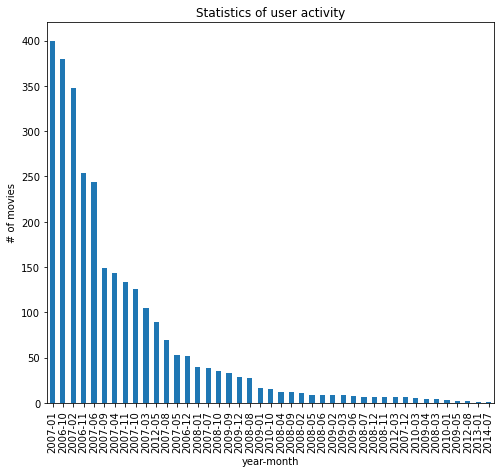

In [62]:
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['time']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['time'] = old_df['time'].replace([old_time], new_time) # replace the time column

converted_df['time'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')

해당 사용자는 대략 2007년 전후로 영화 시청을 가장 많이 했고, 시간이 지나면서 시청 기록이 점점 줄어드는 확인할 수 있습니다.

이어서 사용자가 처음으로 또는 마지막으로 영화 시청을 한 시기도 직접 출력해볼 수 있겠습니다. 또, 다른 사용자들의 분포는 얼마나 다를까요?
혹은, 어떤 영화가 어떤 연도에 가장 많이 소비되었을까요?

눈치 채셨을지 모르겠지만, 앞서 저장했던 *popular_movie_id* 변수는 시각화에 사용되지 않았는데요. 선택 과제로 활용해보시기 바랍니다!

## 마치며

여기까지 오시느라 모두 수고 많으셨습니다. 본 미션에서는 여러 데이터를 관찰하고, 또 분포를 출력해보면서 데이터에 대해 이해하는 시간을 가져보았는데요.
미션에서 제공된 정보 외에도 다른 분석들을 추가로 해보시면 대회를 준비하는데 더 도움이 될 것입니다.
많은 인사이트를 얻어가셔서 대회에 충분히 활용하시길 바라겠습니다!